In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from Utils.dataset import PreloadedDataset
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from Deep_Learning.Experimental.Forward_Forward.network import Feedforward
import math

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else "cpu"
# device = torch.device('cpu')
device

device(type='cuda')

In [3]:
# Will mix two numbers of same class 1/num_classes of the time
class MakeNegativeSample():
    def __init__(self, dataset):
        self.dataset = dataset
        self.n = len(dataset)
    def __call__(self, x, _=None):
        i = torch.randint(0, self.n-1, (x.shape[0],))
        return mix_images(x, self.dataset[i][0])

def mix_images(x1, x2, steps=10):
    device = x1.device
    mask = torch.bernoulli(torch.ones((28,28))*0.5).unsqueeze(0).unsqueeze(0).to(device)
    # blur  with a filter of the form [1/4, 1/2, 1/4] in both horizontal and veritical directions
    filter_h = torch.tensor([[1/4, 1/2, 1/4]]).to(device)
    filter_v = torch.tensor([[1/4], [1/2], [1/4]]).to(device)
    for _ in range(5):
        mask = F.conv2d(mask, filter_h.unsqueeze(0).unsqueeze(0), padding='same')
        mask = F.conv2d(mask, filter_v.unsqueeze(0).unsqueeze(0), padding='same')
    
    # threshold at 0.5
    mask_1 = mask > 0.5
    mask_2 = mask <= 0.5

    out = x1*mask_1 + x2*mask_2
    return out.squeeze(0)


  0%|          | 0/48000 [00:00<?, ?it/s]

Loaded MNIST with 48000 samples


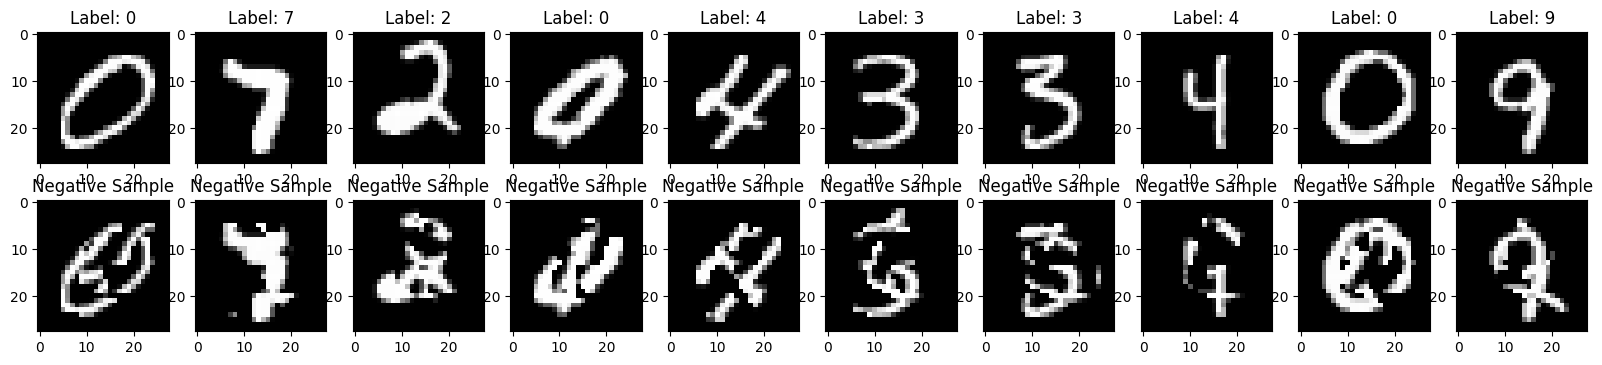

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

raw_dataset = datasets.MNIST(root="../Datasets/", train=True, transform=transform, download=True)
# subset_size = 10000
# raw_dataset = torch.utils.data.Subset(raw_dataset, range(subset_size))

VAL_RATIO = 0.2
n_val = int(len(raw_dataset) * VAL_RATIO)
n_train = len(raw_dataset) - n_val
train_dataset, val_dataset = torch.utils.data.random_split(raw_dataset, [n_train, n_val])


pos_dataset = PreloadedDataset.from_dataset(train_dataset, None, device)
neg_dataset = PreloadedDataset.from_dataset(pos_dataset, MakeNegativeSample(pos_dataset), device)
val_pos_dataset = PreloadedDataset.from_dataset(val_dataset, transforms.ToTensor(), device)
val_neg_dataset = PreloadedDataset.from_dataset(val_pos_dataset, MakeNegativeSample(val_pos_dataset), device)

print(f'Loaded MNIST with {len(pos_dataset)} samples')
# show first samples
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0,i].imshow(pos_dataset[i][0].cpu().permute(1, 2, 0), cmap='gray')
    axs[0,i].set_title(f"Label: {pos_dataset[i][1]}")
    # axs[1,i].imshow(np.squeeze(neg_dataset[i][0].cpu().numpy()), cmap='gray')
    axs[1,i].imshow(neg_dataset[i][0].cpu().permute(1, 2, 0), cmap='gray')
    axs[1,i].set_title(f"Negative Sample")
plt.show()

In [55]:
def train(
    model,
    optimiser,
    pos_dataset,
    neg_dataset,
    val_pos_dataset,
    val_neg_dataset,
    epochs=20,
    batch_size=256,
    mode='minimise',
    neg_coeff=1.0,
    peer_norm_coeff=1.0,
    epochs_pos_actv=None,
    epochs_neg_actv=None,
    epochs_val_pos_actv=None,
    epochs_val_neg_actv=None,
    epochs_pos_norm=None,
    epochs_neg_norm=None,
    epochs_val_pos_norm=None,
    epochs_val_neg_norm=None,
    weights_tracker=None,
    steps=None,
    track_weights=False,
):
    if type(epochs) == int:
        epochs = [epochs for layer in model.layers]
    assert mode in ['minimise', 'maximise'], "Mode must be either 'minimise' or 'maximise'"
    if epochs_pos_actv is None:
        epochs_pos_actv     = [torch.empty((epochs[layer_i], model.layers[layer_i].out_features)) for layer_i in range(len(model.layers))]
        epochs_neg_actv     = [torch.empty((epochs[layer_i], model.layers[layer_i].out_features)) for layer_i in range(len(model.layers))]
        epochs_val_pos_actv = [torch.empty((epochs[layer_i], model.layers[layer_i].out_features)) for layer_i in range(len(model.layers))]
        epochs_val_neg_actv = [torch.empty((epochs[layer_i], model.layers[layer_i].out_features)) for layer_i in range(len(model.layers))]
        epochs_pos_norm =     [torch.empty((epochs[layer_i],)) for layer_i in range(len(model.layers))]
        epochs_neg_norm =     [torch.empty((epochs[layer_i],)) for layer_i in range(len(model.layers))]
        epochs_val_pos_norm = [torch.empty((epochs[layer_i],)) for layer_i in range(len(model.layers))]
        epochs_val_neg_norm = [torch.empty((epochs[layer_i],)) for layer_i in range(len(model.layers))]
        

    if weights_tracker is None:
        weights_tracker = [torch.empty((epochs[layer_i], model.layers[layer_i].out_features, model.layers[layer_i].in_features)) for layer_i in range(len(model.layers))]
    if steps is None:
        steps = [0 for layer in model.layers]

    # Track epochs indexed: [layer][epoch]
    if track_weights and steps[0] == 0:
        for layer_i in range(len(model.layers)):
            weights_tracker[layer_i][0] = model.layers[layer_i].weight.data.clone()

    # Learning Loop
    for layer_i in range(len(model.layers)):
        for ep in range(epochs[layer_i]):

            pos_dataloader = DataLoader(pos_dataset, batch_size=batch_size, shuffle=True)
            neg_dataset.apply_transform()
            neg_dataloader = iter(DataLoader(neg_dataset, batch_size=batch_size, shuffle=True))
            val_pos_dataloader = DataLoader(val_pos_dataset, batch_size=batch_size, shuffle=False)
            val_neg_dataset.apply_transform()
            val_neg_dataloader = iter(DataLoader(val_neg_dataset, batch_size=batch_size, shuffle=True))
            loop = tqdm(enumerate(pos_dataloader), total=len(pos_dataloader), leave=False)
            if ep > 0:
                loop.set_description(f"Epoch {ep+1}/{epochs[layer_i]} - Layer {layer_i}/{len(epochs)-1} - Mean Norms (pos/neg): {epochs_pos_norm[layer_i][ep-1].item():.3f} / {epochs_neg_norm[layer_i][ep-1].item():.3f}")

            batches_pos_actv_total = torch.zeros((model.layers[layer_i].out_features)).to(device)
            batches_neg_actv_total = torch.zeros((model.layers[layer_i].out_features)).to(device)
            batches_pos_norm_total = torch.zeros((1)).to(device)
            batches_neg_norm_total = torch.zeros((1)).to(device)
            for batch_i, (x, y) in loop:
                model.zero_grad()

                # Positive Pass
                x = x.flatten(start_dim=1)

                with torch.no_grad():
                    out, x = model(x, layer_i)
                model.layers[layer_i].weight.grad = (out * torch.sigmoid(out.square().mean() - model.target_actvs[layer_i])).t() @ F.normalize(x, dim=1) * 2/out.numel()
                # model.layers[layer_i].weight.grad += peer_norm_coeff * (out - model.target_actvs[layer_i]).t() @ x

                # out, x = model(x, layer_i)
                # loss = torch.log(1 + torch.exp(out.square().mean() - model.target_actvs[layer_i]))
                # loss.backward()
                # with torch.no_grad():
                #     grad = (out * torch.sigmoid(out.square().mean() - model.target_actvs[layer_i])).t() @ F.normalize(x, dim=1) * 2/out.numel()
                #     assert((model.layers[layer_i].weight.grad - grad).abs().max() < 1e-8)

                # Track batches
                batches_pos_actv_total += out.detach().sum(dim=0)
                batches_pos_norm_total += out.detach().norm(dim=1).sum()
            
                # Negative Pass
                x, y = next(neg_dataloader)
                x = x.flatten(start_dim=1)

                with torch.no_grad():
                    out, x = model(x, layer_i)
                model.layers[layer_i].weight.grad += neg_coeff * (out * -torch.sigmoid(-out.square().mean() + model.target_actvs[layer_i])).t() @ F.normalize(x, dim=1) * 2/out.numel()
                # model.layers[layer_i].weight.grad += peer_norm_coeff * (out - model.target_actvs[layer_i]).t() @ x

                # out, x = model(x, layer_i)
                # loss = neg_coeff * torch.log(1 + torch.exp(-out.square().mean() + model.target_actvs[layer_i]))
                # loss.backward()
                # with torch.no_grad():
                #     grad += neg_coeff * (out * -torch.sigmoid(-out.square().mean() + model.target_actvs[layer_i])).t() @ F.normalize(x, dim=1) * 2/out.numel()
                #     assert((model.layers[layer_i].weight.grad - grad).abs().max() < 1e-8)
                #     model.zero_grad()
                #     model.layers[layer_i].weight.grad = grad

                if mode == 'maximise':
                    model.layers[layer_i].weight.grad *= -1
                optimiser.step()
                # Track final activations (to compare mean similarity for analysis of peer norm)
                batches_neg_actv_total += out.detach().sum(dim=0)
                batches_neg_norm_total += out.detach().norm(dim=1).sum()

            # Track epochs
            epochs_pos_actv[layer_i][ep] = batches_pos_actv_total / len(pos_dataset)
            epochs_neg_actv[layer_i][ep] = batches_neg_actv_total / len(pos_dataset)
            epochs_pos_norm[layer_i][ep] = batches_pos_norm_total / len(pos_dataset)
            epochs_neg_norm[layer_i][ep] = batches_neg_norm_total / len(pos_dataset)
            steps[layer_i] += len(pos_dataset)
            if track_weights:
                weights_tracker[layer_i][ep] = model.layers[layer_i].weight.data.clone()
            
            # Eval 
            batches_val_pos_actv_total = torch.zeros((model.layers[layer_i].out_features)).to(device)
            batches_val_neg_actv_total = torch.zeros((model.layers[layer_i].out_features)).to(device)
            batches_val_pos_norm_total = torch.zeros((1)).to(device)
            batches_val_neg_norm_total = torch.zeros((1)).to(device)
            for batch_i, (x, y) in enumerate(val_pos_dataloader):
                x = x.flatten(start_dim=1)
                with torch.no_grad():
                    out = model(x, layer_i)[0]
                # Track batches
                batches_val_pos_actv_total += out.sum(dim=0)
                batches_val_pos_norm_total += out.norm(dim=1).sum()
            
                # Negative Pass
                x, y = next(val_neg_dataloader)
                x = x.flatten(start_dim=1)
                with torch.no_grad():
                    out = model(x, layer_i)[0]

                # Collect sum of norms across all batches
                batches_val_neg_actv_total += out.sum(dim=0)
                batches_val_neg_norm_total += out.norm(dim=1).sum()

            # Track mean norms over epochs
            epochs_val_pos_actv[layer_i][ep] = batches_val_pos_actv_total / len(val_pos_dataset)
            epochs_val_neg_actv[layer_i][ep] = batches_val_neg_actv_total / len(val_pos_dataset)
            epochs_val_pos_norm[layer_i][ep] = batches_val_pos_norm_total / len(val_pos_dataset)
            epochs_val_neg_norm[layer_i][ep] = batches_val_neg_norm_total / len(val_pos_dataset)

    return epochs_pos_actv, epochs_neg_actv, epochs_val_pos_actv, epochs_val_neg_actv, epochs_pos_norm, epochs_neg_norm, epochs_val_pos_norm, epochs_val_neg_norm, weights_tracker, steps

In [65]:
torch.manual_seed(42)

# Hyperparameters
lr = 0.03
reg_coeff = 0.0

# Parameter Initialisation
sizes = [784, 500, 500, 500]
model = Feedforward(sizes, bias=False, dropout=0.0).to(device)
optimiser = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=reg_coeff)
# optimiser = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=reg_coeff)
pos_actv, neg_actv, val_pos_actv, val_neg_actv, pos_norm, neg_norm, val_pos_norm, val_neg_norm, weights_tracker, steps = None, None, None, None, None, None, None, None, None, None

In [66]:
BATCH_SIZE = 512
EPOCHS = 100
pos_actv, neg_actv, val_pos_actv, val_neg_actv, pos_norm, neg_norm, val_pos_norm, val_neg_norm, weights_tracker, steps = train(
    model,
    optimiser,
    pos_dataset,
    neg_dataset,
    val_pos_dataset,
    val_neg_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    mode='minimise',
    neg_coeff=1.0,
    peer_norm_coeff=0.01,
    epochs_pos_actv=pos_actv,
    epochs_neg_actv=neg_actv,
    epochs_val_pos_actv=val_pos_actv,
    epochs_val_neg_actv=val_neg_actv,
    epochs_pos_norm=pos_norm,
    epochs_neg_norm=neg_norm,
    epochs_val_pos_norm=val_pos_norm,
    epochs_val_neg_norm=val_neg_norm,
    weights_tracker=weights_tracker,
    steps=steps,
    track_weights=True,
)

C:\Users\joeag\AppData\Local\Temp\ipykernel_31444\1557138697.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diff = (torch.tensor(pos_norm[i]) - torch.tensor(neg_norm[i])).abs().numpy()
C:\Users\joeag\AppData\Local\Temp\ipykernel_31444\1557138697.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diff = (torch.tensor(val_pos_norm[i]) - torch.tensor(val_neg_norm[i])).abs().numpy()


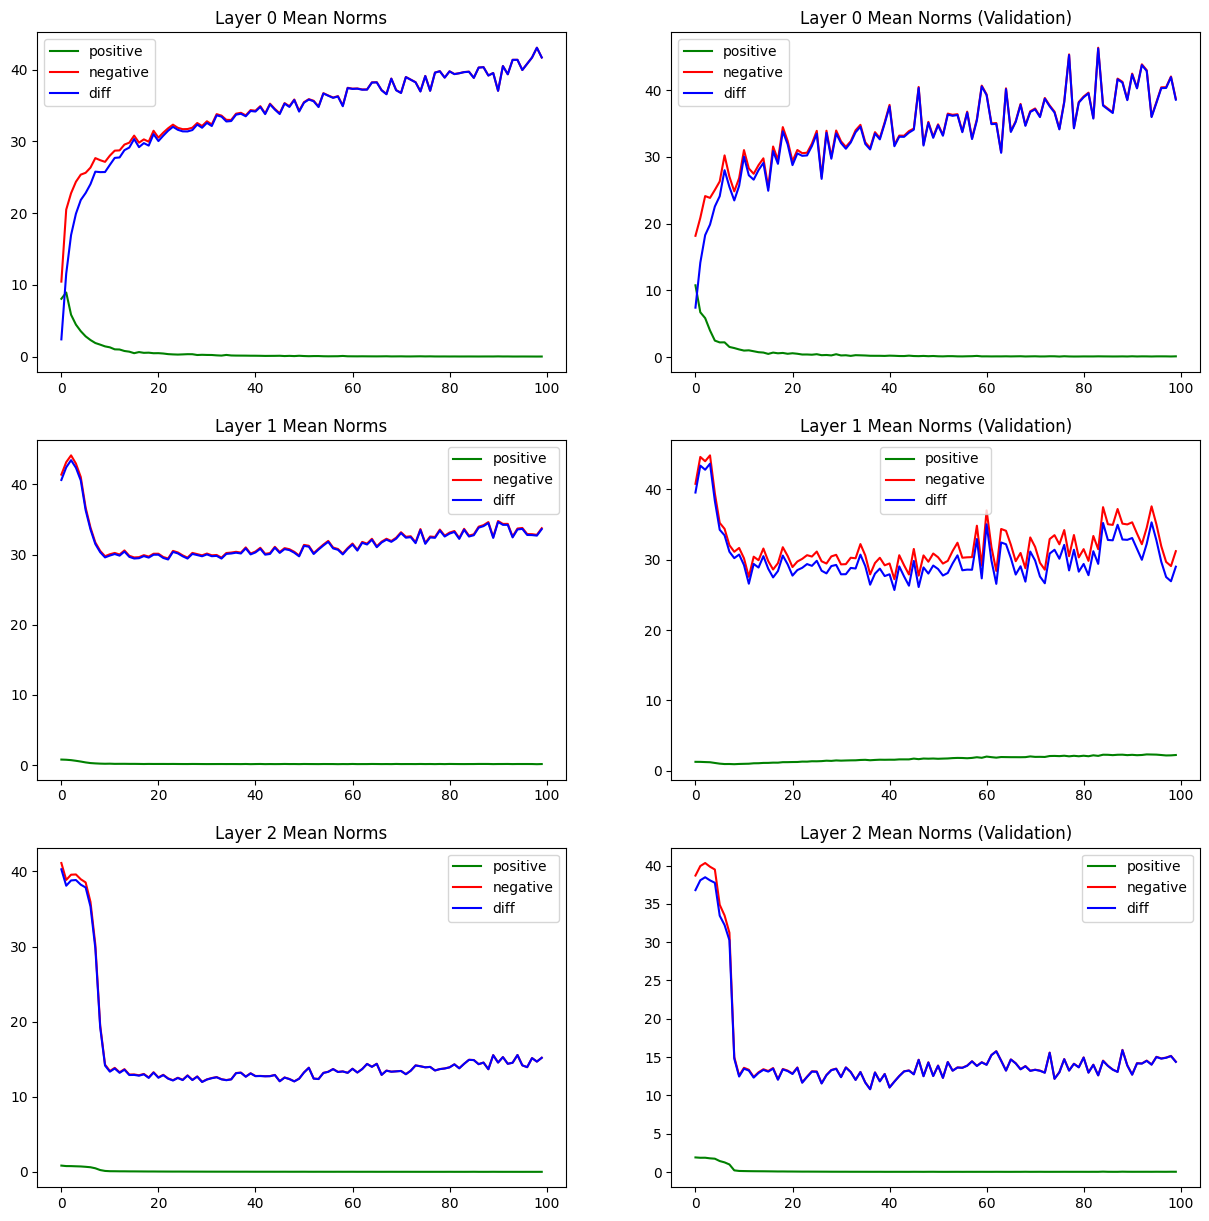

In [67]:
fig, axs = plt.subplots(len(model.layers), 2, figsize=(15, 15))
for i, layer in enumerate(model.layers):
    diff = (torch.tensor(pos_norm[i]) - torch.tensor(neg_norm[i])).abs().numpy()
    axs[i, 0].plot(pos_norm[i], label="positive", color="green")
    axs[i, 0].plot(neg_norm[i], label="negative", color="red")
    axs[i, 0].plot(diff, label="diff", color="blue")
    axs[i, 0].set_title(f"Layer {i} Mean Norms")
    axs[i, 0].legend()

    diff = (torch.tensor(val_pos_norm[i]) - torch.tensor(val_neg_norm[i])).abs().numpy()
    axs[i, 1].plot(val_pos_norm[i], label="positive", color="green")
    axs[i, 1].plot(val_neg_norm[i], label="negative", color="red")
    axs[i, 1].plot(diff, label="diff", color="blue")
    axs[i, 1].set_title(f"Layer {i} Mean Norms (Validation)")
    axs[i, 1].legend()
plt.show()

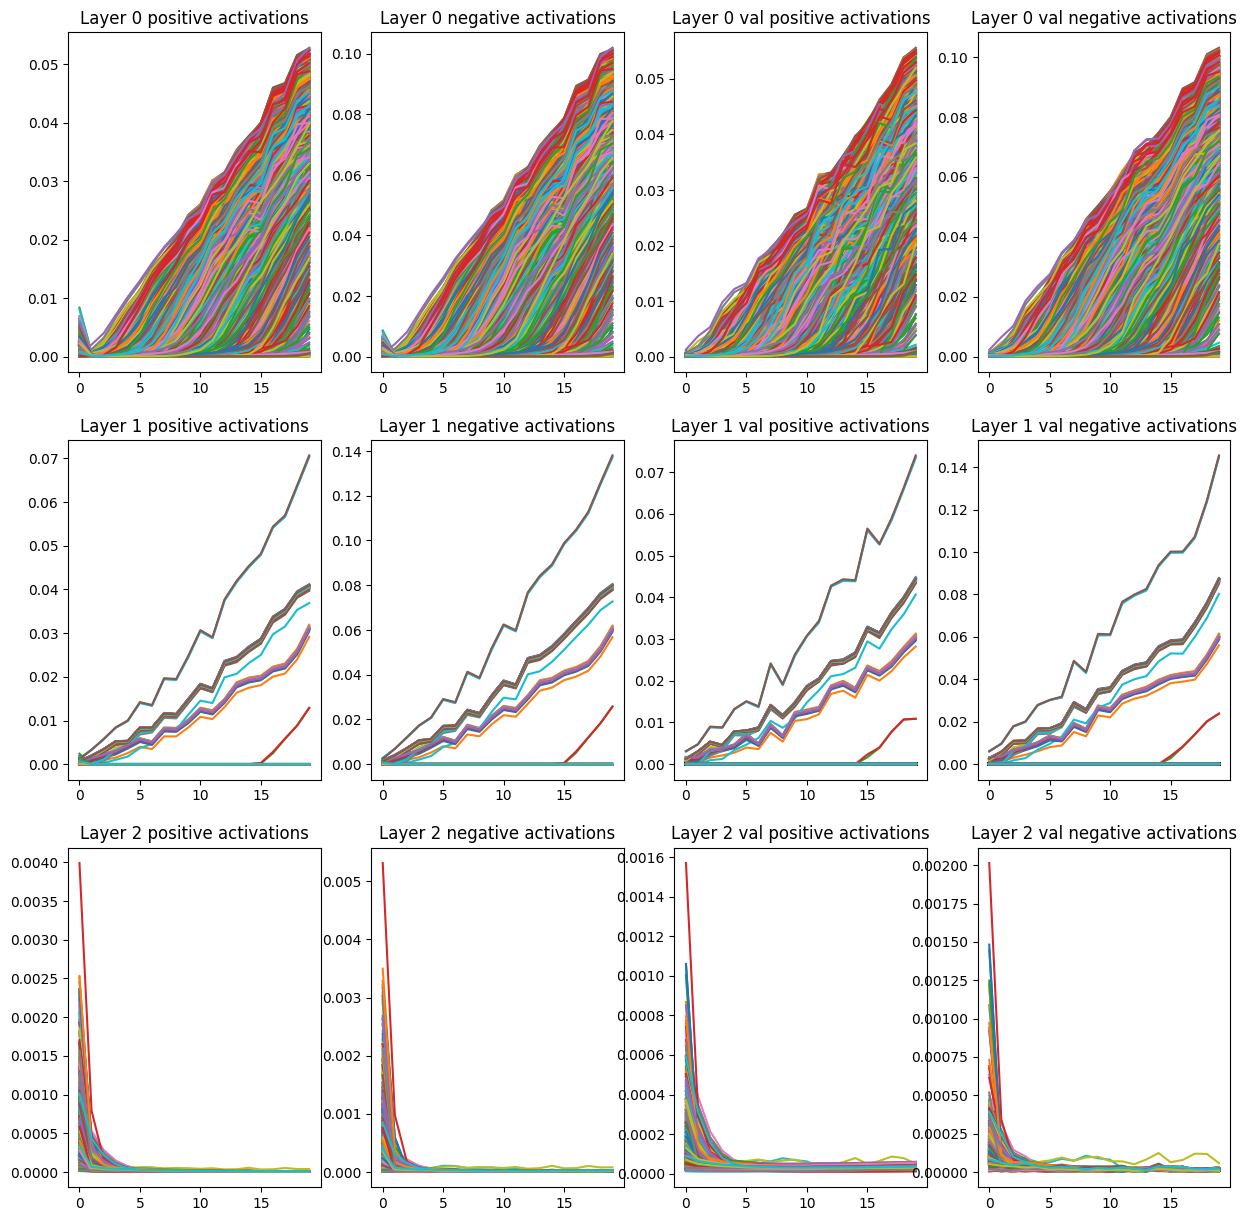

In [57]:
fig, axs = plt.subplots(len(model.layers), 4, figsize=(15, 15))
for i, layer in enumerate(model.layers):
    axs[i, 0].plot(pos_actv[i])
    axs[i, 0].set_title(f"Layer {i} positive activations")
    axs[i, 1].plot(neg_actv[i])
    axs[i, 1].set_title(f"Layer {i} negative activations")

    axs[i, 2].plot(val_pos_actv[i])
    axs[i, 2].set_title(f"Layer {i} val positive activations")
    axs[i, 3].plot(val_neg_actv[i])
    axs[i, 3].set_title(f"Layer {i} val negative activations")
plt.show()

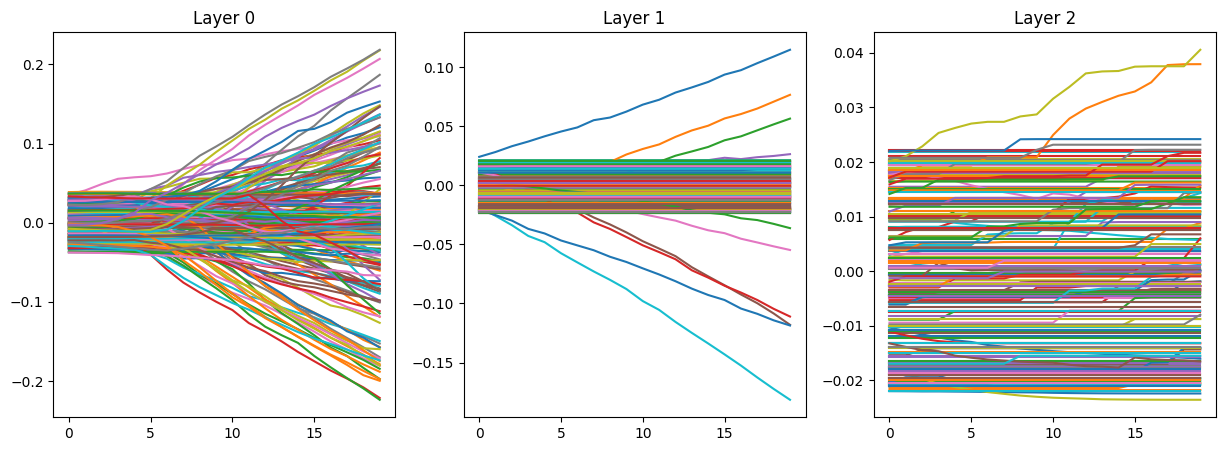

In [58]:
k = 200
weights = [weights_tracker[i].flatten(start_dim=1) for i in range(len(weights_tracker))]
perms = [torch.randperm(weights[i].shape[1]) for i in range(len(weights))]
idxs = [perms[i][:k] for i in range(len(weights))]
weights = [weights[i][:, idxs[i]] for i in range(len(weights))]
fig, axs = plt.subplots(1, len(model.layers), figsize=(15, 5))
for i in range(len(model.layers)):
    axs[i].plot(weights[i])
    axs[i].set_title(f'Layer {i}')
plt.show()

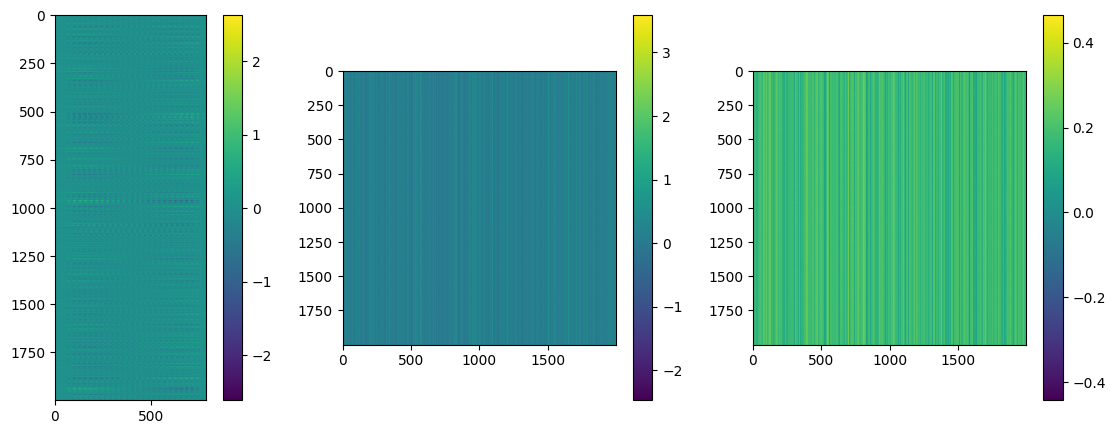

In [12]:
# Plot weights
plt.figure(figsize=(15, 5))
for i, l in enumerate(model.layers):
    plt.subplot(1, len(model.layers), i+1)
    plt.imshow(l.weight.data.cpu().numpy())
    plt.colorbar()
plt.show()